In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
from Bio import SeqIO
import sys
sys.path.insert(0, '../models/')
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=""

from tensorflow.keras.layers import *
from tensorflow.keras import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, CSVLogger
from tensorflow.keras.regularizers import L2
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
#from tensorflow_addons.layers import GroupNormalization

import numpy as np
import h5py
import scipy.io
np.random.seed(1337) # for reproducibility

from tensorflow.keras.layers import Input, Conv1D, Dense, LSTM, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation, AveragePooling1D
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

from random import shuffle
#from pyfasta import Fasta
import gzip
import numpy as np
import re
import random


2025-03-12 09:36:05.093352: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-12 09:36:05.123142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-12 09:36:05.163553: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-12 09:36:05.173566: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-12 09:36:05.200003: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import tensorflow as tf
print("Num of GPUs available: ", len(tf.test.gpu_device_name()))

Num GPUs Available:  0
Num of GPUs available:  0


2025-03-12 09:36:08.666423: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-03-12 09:36:08.666508: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:135] retrieving CUDA diagnostic information for host: ece-ashrafa-6s.eng.umanitoba.ca
2025-03-12 09:36:08.666524: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:142] hostname: ece-ashrafa-6s.eng.umanitoba.ca
2025-03-12 09:36:08.667050: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:166] libcuda reported version is: 530.30.2
2025-03-12 09:36:08.667185: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] kernel reported version is: 530.30.2
2025-03-12 09:36:08.667195: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:249] kernel version seems to match DSO: 530.30.2


In [3]:
from Bio import SeqIO

pos_seq = []
for seq_record in SeqIO.parse('../Dataset/S1-pos.txt', "fasta"):
    pos_seq.append(str(seq_record.seq))

# Calculate the minimum and maximum sequence lengths
min_length = min(len(seq) for seq in pos_seq)
max_length = max(len(seq) for seq in pos_seq)

# Print the results
print(f"Minimum sequence length: {min_length}")
print(f"Maximum sequence length: {max_length}")


Minimum sequence length: 220
Maximum sequence length: 275


In [4]:
from Bio import SeqIO

pos_seq = []
for seq_record in SeqIO.parse('../Dataset/S1-pos.txt', "fasta"):
    pos_seq.append(str(seq_record.seq.upper()))

# Calculate the maximum sequence length
max_length = max(len(seq) for seq in pos_seq)

# Pad all sequences to the maximum length
padded_pos_seq = [seq.ljust(max_length, 'N') for seq in pos_seq]

# Example: Print the first padded sequence and its length
print(f"Padded first sequence: {padded_pos_seq[0]}")
print(f"Length of padded first sequence: {len(padded_pos_seq[0])}")

# You can also print the max length for confirmation
print(f"Maximum sequence length: {max_length}")


Padded first sequence: CTTCGCCAGCCACTCTTAGTCCGCCAGCGCGTGCGGCGGAGGCCGAGCGTCTCTATGATCCTGGCTTCTGGCAACGTCATCGTCACGCGCCGGATCCAACCCCCAACCACTTTAGCCAGCTCTAGAGGCGCGCGTGGCCGGGACGGAAGTGCGCGCGGGTGTCGCCGGGAGTGCGCGCTCCTCTGGCTGACGGGCGGGCCGGGCATGCGCCGCGGGCGTTTTGGCGGGAAGCGCGGGGCGGGCCGGACAATGAGAGTGTCCGCCTCCNNNNNNNN
Length of padded first sequence: 275
Maximum sequence length: 275


In [5]:
from Bio import SeqIO

neg_seq = []
for seq_record in SeqIO.parse('../Dataset/S1-neg.txt', "fasta"):
    neg_seq.append(str(seq_record.seq.upper()))

# Calculate the maximum sequence length
max_length = max(len(seq) for seq in neg_seq)

# Pad all sequences to the maximum length
padded_neg_seq = [seq.ljust(max_length, 'N') for seq in neg_seq]

# Example: Print the first padded sequence and its length
print(f"Padded first sequence: {padded_neg_seq[0]}")
print(f"Length of padded first sequence: {len(padded_neg_seq[0])}")

# You can also print the max length for confirmation
print(f"Maximum sequence length: {max_length}")


Padded first sequence: GGCTCAGCACACACTTCACTGCTGCCGTCCCACACAGGAGCTCCAGGCTCGGATCAACCCAGCAGCAGGAAAGTCTTCTTCAACAGGGGCCAAGGCAGGATCCCCAAGGAGGCCACCTTCCAGAAACTGCTAAGGAACGAGGTCCGGGGGCCCCAAGCCCTGACTGGCACAGTCAGAGGAAAGTCAGGGCGGAGCTCAGCCCCCGTCCCCTCCCCTCGAGAGCGGGCCTGAGCCCCTGTCTCTCCATNNNNNNNNNNNNNNNNNNNNNNNNNNNN
Length of padded first sequence: 275
Maximum sequence length: 275


In [6]:
combine_seqs = padded_pos_seq + padded_neg_seq

In [7]:
#di_seqs=seq2k_mer(combine_seqs)

In [8]:
import re
def get_feature(all_seqs,patterns):
    all_feat = []
    for seq in all_seqs:
        feat= np.zeros((1,len(patterns)))
        ix=0
        for ix, pattern in enumerate(patterns):
            pat='(?='+pattern+')'
            featcnt=len(re.findall(pat,seq))
            feat[0,ix] = featcnt
            ix+=1
        all_feat.append(feat)
    return np.asarray(all_feat)

#patterns= ['AA','AC','AT','AG','CA','CC','CT','CG','TA','TC','TT','TG','GA','GC','GT','GG']
#patterns= ['AAA','AAC','AAT','AAG','ACA','ACC','ACT', 'ACG','ATA','ATC','ATT','ATG','AGA','AGC','AGT', 'AGG','CAA','CAC','CAT','CAG','TAA','TAC','TAT', 'TAG','GAA','GAC','GAT','GAG','CCA','CCC','CCT', 'CCG','TTA','TTC','TTT','TTG','GGA','GGC','GGT', 'GGG','TCA','TCC','TCT','TCG','GCA','GCC','GCT','GCG','CTA','CTC','CTT','CTG','GTA','GTC','GTT','AGG','CGA','CGC','CGT','GGG','TTT','ATA','CTA', 'GTA']#patterns=['AAAA','AAAC','AAAG','AAAU','AACA','AACC','AACG','AACU','AAGA','AAGC','AAGG','AAGU','AAUA','AAUC','AAUG','AAUU','ACAA','ACAC','ACAG','ACAU','ACCA','ACCC','ACCG','ACCU','ACGA','ACGC','ACGG','ACGU','ACUA','ACUC','ACUG','ACUU','AGAA','AGAC','AGAG','AGAU','AGCA','AGCC','AGCG','AGCU','AGGA','AGGC','AGGG','AGGU','AGUA','AGUC','AGUG','AGUU','AUAA','AUAC','AUAG','AUAU','AUCA','AUCC','AUCG','AUCU','AUGA','AUGC','AUGG','AUGU','AUUA','AUUC','AUUG','AUUU','CAAA','CAAC','CAAG','CAAU','CACA','CACC','CACG','CACU','CAGA','CAGC','CAGG','CAGU','CAUA','CAUC','CAUG','CAUU','CCAA','CCAC','CCAG','CCAU','CCCA','CCCC','CCCG','CCCU','CCGA','CCGC','CCGG','CCGU','CCUA','CCUC','CCUG','CCUU','CGAA','CGAC','CGAG','CGAU','CGCA','CGCC','CGCG','CGCU','CGGA','CGGC','CGGG','CGGU','CGUA','CGUC','CGUG','CGUU','CUAA','CUAC','CUAG','CUAU','CUCA','CUCC','CUCG','CUCU','CUGA','CUGC','CUGG','CUGU','CUUA','CUUC','CUUG','CUUU','GAAA','GAAC','GAAG','GAAU','GACA','GACC','GACG','GACU','GAGA','GAGC','GAGG','GAGU','GAUA','GAUC','GAUG','GAUU','GCAA','GCAC','GCAG','GCAU','GCCA','GCCC','GCCG','GCCU','GCGA','GCGC','GCGG','GCGU','GCUA','GCUC','GCUG','GCUU','GGAA','GGAC','GGAG','GGAU','GGCA','GGCC','GGCG','GGCU','GGGA','GGGC','GGGG','GGGU','GGUA','GGUC','GGUG','GGUU','GUAA','GUAC','GUAG','GUAU','GUCA','GUCC','GUCG','GUCU','GUGA','GUGC','GUGG','GUGU','GUUA','GUUC','GUUG','GUUU','UAAA','UAAC','UAAG','UAAU','UACA','UACC','UACG','UACU','UAGA','UAGC','UAGG','UAGU','UAUA','UAUC','UAUG','UAUU','UCAA','UCAC','UCAG','UCAU','UCCA','UCCC','UCCG','UCCU','UCGA','UCGC','UCGG','UCGU','UCUA','UCUC','UCUG','UCUU','UGAA','UGAC','UGAG','UGAU','UGCA','UGCC','UGCG','UGCU','UGGA','UGGC','UGGG','UGGU','UGUA','UGUC','UGUG','UGUU','UUAA','UUAC','UUAG','UUAU','UUCA','UUCC','UUCG','UUCU','UUGA','UUGC','UUGG','UUGU','UUUA','UUUC','UUUG','UUUU']
#patterns=['AAAAA','AAAAC','AAAAG','AAAAU','AAACA','AAACC','AAACG','AAACU','AAAGA','AAAGC','AAAGG','AAAGU','AAAUA','AAAUC','AAAUG','AAAUU','AACAA','AACAC','AACAG','AACAU','AACCA','AACCC','AACCG','AACCU','AACGA','AACGC','AACGG','AACGU','AACUA','AACUC','AACUG','AACUU','AAGAA','AAGAC','AAGAG','AAGAU','AAGCA','AAGCC','AAGCG','AAGCU','AAGGA','AAGGC','AAGGG','AAGGU','AAGUA','AAGUC','AAGUG','AAGUU','AAUAA','AAUAC','AAUAG','AAUAU','AAUCA','AAUCC','AAUCG','AAUCU','AAUGA','AAUGC','AAUGG','AAUGU','AAUUA','AAUUC','AAUUG','AAUUU','ACAAA','ACAAC','ACAAG','ACAAU','ACACA','ACACC','ACACG','ACACU','ACAGA','ACAGC','ACAGG','ACAGU','ACAUA','ACAUC','ACAUG','ACAUU','ACCAA','ACCAC','ACCAG','ACCAU','ACCCA','ACCCC','ACCCG','ACCCU','ACCGA','ACCGC','ACCGG','ACCGU','ACCUA','ACCUC','ACCUG','ACCUU','ACGAA','ACGAC','ACGAG','ACGAU','ACGCA','ACGCC','ACGCG','ACGCU','ACGGA','ACGGC','ACGGG','ACGGU','ACGUA','ACGUC','ACGUG','ACGUU','ACUAA','ACUAC','ACUAG','ACUAU','ACUCA','ACUCC','ACUCG','ACUCU','ACUGA','ACUGC','ACUGG','ACUGU','ACUUA','ACUUC','ACUUG','ACUUU','AGAAA','AGAAC','AGAAG','AGAAU','AGACA','AGACC','AGACG','AGACU','AGAGA','AGAGC','AGAGG','AGAGU','AGAUA','AGAUC','AGAUG','AGAUU','AGCAA','AGCAC','AGCAG','AGCAU','AGCCA','AGCCC','AGCCG','AGCCU','AGCGA','AGCGC','AGCGG','AGCGU','AGCUA','AGCUC','AGCUG','AGCUU','AGGAA','AGGAC','AGGAG','AGGAU','AGGCA','AGGCC','AGGCG','AGGCU','AGGGA','AGGGC','AGGGG','AGGGU','AGGUA','AGGUC','AGGUG','AGGUU','AGUAA','AGUAC','AGUAG','AGUAU','AGUCA','AGUCC','AGUCG','AGUCU','AGUGA','AGUGC','AGUGG','AGUGU','AGUUA','AGUUC','AGUUG','AGUUU','AUAAA','AUAAC','AUAAG','AUAAU','AUACA','AUACC','AUACG','AUACU','AUAGA','AUAGC','AUAGG','AUAGU','AUAUA','AUAUC','AUAUG','AUAUU','AUCAA','AUCAC','AUCAG','AUCAU','AUCCA','AUCCC','AUCCG','AUCCU','AUCGA','AUCGC','AUCGG','AUCGU','AUCUA','AUCUC','AUCUG','AUCUU','AUGAA','AUGAC','AUGAG','AUGAU','AUGCA','AUGCC','AUGCG','AUGCU','AUGGA','AUGGC','AUGGG','AUGGU','AUGUA','AUGUC','AUGUG','AUGUU','AUUAA','AUUAC','AUUAG','AUUAU','AUUCA','AUUCC','AUUCG','AUUCU','AUUGA','AUUGC','AUUGG','AUUGU','AUUUA','AUUUC','AUUUG','AUUUU','CAAAA','CAAAC','CAAAG','CAAAU','CAACA','CAACC','CAACG','CAACU','CAAGA','CAAGC','CAAGG','CAAGU','CAAUA','CAAUC','CAAUG','CAAUU','CACAA','CACAC','CACAG','CACAU','CACCA','CACCC','CACCG','CACCU','CACGA','CACGC','CACGG','CACGU','CACUA','CACUC','CACUG','CACUU','CAGAA','CAGAC','CAGAG','CAGAU','CAGCA','CAGCC','CAGCG','CAGCU','CAGGA','CAGGC','CAGGG','CAGGU','CAGUA','CAGUC','CAGUG','CAGUU','CAUAA','CAUAC','CAUAG','CAUAU','CAUCA','CAUCC','CAUCG','CAUCU','CAUGA','CAUGC','CAUGG','CAUGU','CAUUA','CAUUC','CAUUG','CAUUU','CCAAA','CCAAC','CCAAG','CCAAU','CCACA','CCACC','CCACG','CCACU','CCAGA','CCAGC','CCAGG','CCAGU','CCAUA','CCAUC','CCAUG','CCAUU','CCCAA','CCCAC','CCCAG','CCCAU','CCCCA','CCCCC','CCCCG','CCCCU','CCCGA','CCCGC','CCCGG','CCCGU','CCCUA','CCCUC','CCCUG','CCCUU','CCGAA','CCGAC','CCGAG','CCGAU','CCGCA','CCGCC','CCGCG','CCGCU','CCGGA','CCGGC','CCGGG','CCGGU','CCGUA','CCGUC','CCGUG','CCGUU','CCUAA','CCUAC','CCUAG','CCUAU','CCUCA','CCUCC','CCUCG','CCUCU','CCUGA','CCUGC','CCUGG','CCUGU','CCUUA','CCUUC','CCUUG','CCUUU','CGAAA','CGAAC','CGAAG','CGAAU','CGACA','CGACC','CGACG','CGACU','CGAGA','CGAGC','CGAGG','CGAGU','CGAUA','CGAUC','CGAUG','CGAUU','CGCAA','CGCAC','CGCAG','CGCAU','CGCCA','CGCCC','CGCCG','CGCCU','CGCGA','CGCGC','CGCGG','CGCGU','CGCUA','CGCUC','CGCUG','CGCUU','CGGAA','CGGAC','CGGAG','CGGAU','CGGCA','CGGCC','CGGCG','CGGCU','CGGGA','CGGGC','CGGGG','CGGGU','CGGUA','CGGUC','CGGUG','CGGUU','CGUAA','CGUAC','CGUAG','CGUAU','CGUCA','CGUCC','CGUCG','CGUCU','CGUGA','CGUGC','CGUGG','CGUGU','CGUUA','CGUUC','CGUUG','CGUUU','CUAAA','CUAAC','CUAAG','CUAAU','CUACA','CUACC','CUACG','CUACU','CUAGA','CUAGC','CUAGG','CUAGU','CUAUA','CUAUC','CUAUG','CUAUU','CUCAA','CUCAC','CUCAG','CUCAU','CUCCA','CUCCC','CUCCG','CUCCU','CUCGA','CUCGC','CUCGG','CUCGU','CUCUA','CUCUC','CUCUG','CUCUU','CUGAA','CUGAC','CUGAG','CUGAU','CUGCA','CUGCC','CUGCG','CUGCU','CUGGA','CUGGC','CUGGG','CUGGU','CUGUA','CUGUC','CUGUG','CUGUU','CUUAA','CUUAC','CUUAG','CUUAU','CUUCA','CUUCC','CUUCG','CUUCU','CUUGA','CUUGC','CUUGG','CUUGU','CUUUA','CUUUC','CUUUG','CUUUU','GAAAA','GAAAC','GAAAG','GAAAU','GAACA','GAACC','GAACG','GAACU','GAAGA','GAAGC','GAAGG','GAAGU','GAAUA','GAAUC','GAAUG','GAAUU','GACAA','GACAC','GACAG','GACAU','GACCA','GACCC','GACCG','GACCU','GACGA','GACGC','GACGG','GACGU','GACUA','GACUC','GACUG','GACUU','GAGAA','GAGAC','GAGAG','GAGAU','GAGCA','GAGCC','GAGCG','GAGCU','GAGGA','GAGGC','GAGGG','GAGGU','GAGUA','GAGUC','GAGUG','GAGUU','GAUAA','GAUAC','GAUAG','GAUAU','GAUCA','GAUCC','GAUCG','GAUCU','GAUGA','GAUGC','GAUGG','GAUGU','GAUUA','GAUUC','GAUUG','GAUUU','GCAAA','GCAAC','GCAAG','GCAAU','GCACA','GCACC','GCACG','GCACU','GCAGA','GCAGC','GCAGG','GCAGU','GCAUA','GCAUC','GCAUG','GCAUU','GCCAA','GCCAC','GCCAG','GCCAU','GCCCA','GCCCC','GCCCG','GCCCU','GCCGA','GCCGC','GCCGG','GCCGU','GCCUA','GCCUC','GCCUG','GCCUU','GCGAA','GCGAC','GCGAG','GCGAU','GCGCA','GCGCC','GCGCG','GCGCU','GCGGA','GCGGC','GCGGG','GCGGU','GCGUA','GCGUC','GCGUG','GCGUU','GCUAA','GCUAC','GCUAG','GCUAU','GCUCA','GCUCC','GCUCG','GCUCU','GCUGA','GCUGC','GCUGG','GCUGU','GCUUA','GCUUC','GCUUG','GCUUU','GGAAA','GGAAC','GGAAG','GGAAU','GGACA','GGACC','GGACG','GGACU','GGAGA','GGAGC','GGAGG','GGAGU','GGAUA','GGAUC','GGAUG','GGAUU','GGCAA','GGCAC','GGCAG','GGCAU','GGCCA','GGCCC','GGCCG','GGCCU','GGCGA','GGCGC','GGCGG','GGCGU','GGCUA','GGCUC','GGCUG','GGCUU','GGGAA','GGGAC','GGGAG','GGGAU','GGGCA','GGGCC','GGGCG','GGGCU','GGGGA','GGGGC','GGGGG','GGGGU','GGGUA','GGGUC','GGGUG','GGGUU','GGUAA','GGUAC','GGUAG','GGUAU','GGUCA','GGUCC','GGUCG','GGUCU','GGUGA','GGUGC','GGUGG','GGUGU','GGUUA','GGUUC','GGUUG','GGUUU','GUAAA','GUAAC','GUAAG','GUAAU','GUACA','GUACC','GUACG','GUACU','GUAGA','GUAGC','GUAGG','GUAGU','GUAUA','GUAUC','GUAUG','GUAUU','GUCAA','GUCAC','GUCAG','GUCAU','GUCCA','GUCCC','GUCCG','GUCCU','GUCGA','GUCGC','GUCGG','GUCGU','GUCUA','GUCUC','GUCUG','GUCUU','GUGAA','GUGAC','GUGAG','GUGAU','GUGCA','GUGCC','GUGCG','GUGCU','GUGGA','GUGGC','GUGGG','GUGGU','GUGUA','GUGUC','GUGUG','GUGUU','GUUAA','GUUAC','GUUAG','GUUAU','GUUCA','GUUCC','GUUCG','GUUCU','GUUGA','GUUGC','GUUGG','GUUGU','GUUUA','GUUUC','GUUUG','GUUUU','UAAAA','UAAAC','UAAAG','UAAAU','UAACA','UAACC','UAACG','UAACU','UAAGA','UAAGC','UAAGG','UAAGU','UAAUA','UAAUC','UAAUG','UAAUU','UACAA','UACAC','UACAG','UACAU','UACCA','UACCC','UACCG','UACCU','UACGA','UACGC','UACGG','UACGU','UACUA','UACUC','UACUG','UACUU','UAGAA','UAGAC','UAGAG','UAGAU','UAGCA','UAGCC','UAGCG','UAGCU','UAGGA','UAGGC','UAGGG','UAGGU','UAGUA','UAGUC','UAGUG','UAGUU','UAUAA','UAUAC','UAUAG','UAUAU','UAUCA','UAUCC','UAUCG','UAUCU','UAUGA','UAUGC','UAUGG','UAUGU','UAUUA','UAUUC','UAUUG','UAUUU','UCAAA','UCAAC','UCAAG','UCAAU','UCACA','UCACC','UCACG','UCACU','UCAGA','UCAGC','UCAGG','UCAGU','UCAUA','UCAUC','UCAUG','UCAUU','UCCAA','UCCAC','UCCAG','UCCAU','UCCCA','UCCCC','UCCCG','UCCCU','UCCGA','UCCGC','UCCGG','UCCGU','UCCUA','UCCUC','UCCUG','UCCUU','UCGAA','UCGAC','UCGAG','UCGAU','UCGCA','UCGCC','UCGCG','UCGCU','UCGGA','UCGGC','UCGGG','UCGGU','UCGUA','UCGUC','UCGUG','UCGUU','UCUAA','UCUAC','UCUAG','UCUAU','UCUCA','UCUCC','UCUCG','UCUCU','UCUGA','UCUGC','UCUGG','UCUGU','UCUUA','UCUUC','UCUUG','UCUUU','UGAAA','UGAAC','UGAAG','UGAAU','UGACA','UGACC','UGACG','UGACU','UGAGA','UGAGC','UGAGG','UGAGU','UGAUA','UGAUC','UGAUG','UGAUU','UGCAA','UGCAC','UGCAG','UGCAU','UGCCA','UGCCC','UGCCG','UGCCU','UGCGA','UGCGC','UGCGG','UGCGU','UGCUA','UGCUC','UGCUG','UGCUU','UGGAA','UGGAC','UGGAG','UGGAU','UGGCA','UGGCC','UGGCG','UGGCU','UGGGA','UGGGC','UGGGG','UGGGU','UGGUA','UGGUC','UGGUG','UGGUU','UGUAA','UGUAC','UGUAG','UGUAU','UGUCA','UGUCC','UGUCG','UGUCU','UGUGA','UGUGC','UGUGG','UGUGU','UGUUA','UGUUC','UGUUG','UGUUU','UUAAA','UUAAC','UUAAG','UUAAU','UUACA','UUACC','UUACG','UUACU','UUAGA','UUAGC','UUAGG','UUAGU','UUAUA','UUAUC','UUAUG','UUAUU','UUCAA','UUCAC','UUCAG','UUCAU','UUCCA','UUCCC','UUCCG','UUCCU','UUCGA','UUCGC','UUCGG','UUCGU','UUCUA','UUCUC','UUCUG','UUCUU','UUGAA','UUGAC','UUGAG','UUGAU','UUGCA','UUGCC','UUGCG','UUGCU','UUGGA','UUGGC','UUGGG','UUGGU','UUGUA','UUGUC','UUGUG','UUGUU','UUUAA','UUUAC','UUUAG','UUUAU','UUUCA','UUUCC','UUUCG','UUUCU','UUUGA','UUUGC','UUUGG','UUUGU','UUUUA','UUUUC','UUUUG','UUUUU']
#patterns= ['A','C','U','G','AA','AC','AU','AG','CA','CC', 'CU','CG','UA','UC','UU','UG','GA','GC','GU', 'GG','AAA','AAC','AAU','AAG','ACA','ACC','ACU', 'ACG','AUA','AUC','AUU','AUG','AGA','AGC','AGU', 'AGG','CAA','CAC','CAU','CAG','UAA','UAC','UAU', 'UAG','GAA','GAC','GAU','GAG','CCA','CCC','CCU', 'CCG','UUA','UUC','UUU','UUG','GGA','GGC','GGU', 'GGG','UCA','UCC','UCU','UCG','GCA','GCC','GCU','GCG','CUA','CUC','CUU','CUG','GUA','GUC','GUU','AGG','CGA','CGC','CGU','GGG','UUU','AUA','CUA', 'GUA']
#patterns=['AAAA','AAAC','AAAG','AAAT','AACA','AACC','AACG','AACT','AAGA','AAGC','AAGG','AAGT','AATA','AATC','AATG','AATT','ACAA','ACAC','ACAG','ACAT','ACCA','ACCC','ACCG','ACCT','ACGA','ACGC','ACGG','ACGT','ACTA','ACTC','ACTG','ACTT','AGAA','AGAC','AGAG','AGAT','AGCA','AGCC','AGCG','AGCT','AGGA','AGGC','AGGG','AGGT','AGTA','AGTC','AGTG','AGTT','ATAA','ATAC','ATAG','ATAT','ATCA','ATCC','ATCG','ATCT','ATGA','ATGC','ATGG','ATGT','ATTA','ATTC','ATTG','ATTT','CAAA','CAAC','CAAG','CAAT','CACA','CACC','CACG','CACT','CAGA','CAGC','CAGG','CAGT','CATA','CATC','CATG','CATT','CCAA','CCAC','CCAG','CCAT','CCCA','CCCC','CCCG','CCCT','CCGA','CCGC','CCGG','CCGT','CCTA','CCTC','CCTG','CCTT','CGAA','CGAC','CGAG','CGAT','CGCA','CGCC','CGCG','CGCT','CGGA','CGGC','CGGG','CGGT','CGTA','CGTC','CGTG','CGTT','CTAA','CTAC','CTAG','CTAT','CTCA','CTCC','CTCG','CTCT','CTGA','CTGC','CTGG','CTGT','CTTA','CTTC','CTTG','CTTT','GAAA','GAAC','GAAG','GAAT','GACA','GACC','GACG','GACT','GAGA','GAGC','GAGG','GAGT','GATA','GATC','GATG','GATT','GCAA','GCAC','GCAG','GCAT','GCCA','GCCC','GCCG','GCCT','GCGA','GCGC','GCGG','GCGT','GCTA','GCTC','GCTG','GCTT','GGAA','GGAC','GGAG','GGAT','GGCA','GGCC','GGCG','GGCT','GGGA','GGGC','GGGG','GGGT','GGTA','GGTC','GGTG','GGTT','GTAA','GTAC','GTAG','GTAT','GTCA','GTCC','GTCG','GTCT','GTGA','GTGC','GTGG','GTGT','GTTA','GTTC','GTTG','GTTT','TAAA','TAAC','TAAG','TAAT','TACA','TACC','TACG','TACT','TAGA','TAGC','TAGG','TAGT','TATA','TATC','TATG','TATT','TCAA','TCAC','TCAG','TCAT','TCCA','TCCC','TCCG','TCCT','TCGA','TCGC','TCGG','TCGT','TCTA','TCTC','TCTG','TCTT','TGAA','TGAC','TGAG','TGAT','TGCA','TGCC','TGCG','TGCT','TGGA','TGGC','TGGG','TGGT','TGTA','TGTC','TGTG','TGTT','TTAA','TTAC','TTAG','TTAT','TTCA','TTCC','TTCG','TTCT','TTGA','TTGC','TTGG','TTGT','TTTA','TTTC','TTTG','TTTT']
patterns=['AAAAA','AAAAC','AAAAG','AAAAT','AAACA','AAACC','AAACG','AAACT','AAAGA','AAAGC','AAAGG','AAAGT','AAATA','AAATC','AAATG','AAATT','AACAA','AACAC','AACAG','AACAT','AACCA','AACCC','AACCG','AACCT','AACGA','AACGC','AACGG','AACGT','AACTA','AACTC','AACTG','AACTT','AAGAA','AAGAC','AAGAG','AAGAT','AAGCA','AAGCC','AAGCG','AAGCT','AAGGA','AAGGC','AAGGG','AAGGT','AAGTA','AAGTC','AAGTG','AAGTT','AATAA','AATAC','AATAG','AATAT','AATCA','AATCC','AATCG','AATCT','AATGA','AATGC','AATGG','AATGT','AATTA','AATTC','AATTG','AATTT','ACAAA','ACAAC','ACAAG','ACAAT','ACACA','ACACC','ACACG','ACACT','ACAGA','ACAGC','ACAGG','ACAGT','ACATA','ACATC','ACATG','ACATT','ACCAA','ACCAC','ACCAG','ACCAT','ACCCA','ACCCC','ACCCG','ACCCT','ACCGA','ACCGC','ACCGG','ACCGT','ACCTA','ACCTC','ACCTG','ACCTT','ACGAA','ACGAC','ACGAG','ACGAT','ACGCA','ACGCC','ACGCG','ACGCT','ACGGA','ACGGC','ACGGG','ACGGT','ACGTA','ACGTC','ACGTG','ACGTT','ACTAA','ACTAC','ACTAG','ACTAT','ACTCA','ACTCC','ACTCG','ACTCT','ACTGA','ACTGC','ACTGG','ACTGT','ACTTA','ACTTC','ACTTG','ACTTT','AGAAA','AGAAC','AGAAG','AGAAT','AGACA','AGACC','AGACG','AGACT','AGAGA','AGAGC','AGAGG','AGAGT','AGATA','AGATC','AGATG','AGATT','AGCAA','AGCAC','AGCAG','AGCAT','AGCCA','AGCCC','AGCCG','AGCCT','AGCGA','AGCGC','AGCGG','AGCGT','AGCTA','AGCTC','AGCTG','AGCTT','AGGAA','AGGAC','AGGAG','AGGAT','AGGCA','AGGCC','AGGCG','AGGCT','AGGGA','AGGGC','AGGGG','AGGGT','AGGTA','AGGTC','AGGTG','AGGTT','AGTAA','AGTAC','AGTAG','AGTAT','AGTCA','AGTCC','AGTCG','AGTCT','AGTGA','AGTGC','AGTGG','AGTGT','AGTTA','AGTTC','AGTTG','AGTTT','ATAAA','ATAAC','ATAAG','ATAAT','ATACA','ATACC','ATACG','ATACT','ATAGA','ATAGC','ATAGG','ATAGT','ATATA','ATATC','ATATG','ATATT','ATCAA','ATCAC','ATCAG','ATCAT','ATCCA','ATCCC','ATCCG','ATCCT','ATCGA','ATCGC','ATCGG','ATCGT','ATCTA','ATCTC','ATCTG','ATCTT','ATGAA','ATGAC','ATGAG','ATGAT','ATGCA','ATGCC','ATGCG','ATGCT','ATGGA','ATGGC','ATGGG','ATGGT','ATGTA','ATGTC','ATGTG','ATGTT','ATTAA','ATTAC','ATTAG','ATTAT','ATTCA','ATTCC','ATTCG','ATTCT','ATTGA','ATTGC','ATTGG','ATTGT','ATTTA','ATTTC','ATTTG','ATTTT','CAAAA','CAAAC','CAAAG','CAAAT','CAACA','CAACC','CAACG','CAACT','CAAGA','CAAGC','CAAGG','CAAGT','CAATA','CAATC','CAATG','CAATT','CACAA','CACAC','CACAG','CACAT','CACCA','CACCC','CACCG','CACCT','CACGA','CACGC','CACGG','CACGT','CACTA','CACTC','CACTG','CACTT','CAGAA','CAGAC','CAGAG','CAGAT','CAGCA','CAGCC','CAGCG','CAGCT','CAGGA','CAGGC','CAGGG','CAGGT','CAGTA','CAGTC','CAGTG','CAGTT','CATAA','CATAC','CATAG','CATAT','CATCA','CATCC','CATCG','CATCT','CATGA','CATGC','CATGG','CATGT','CATTA','CATTC','CATTG','CATTT','CCAAA','CCAAC','CCAAG','CCAAT','CCACA','CCACC','CCACG','CCACT','CCAGA','CCAGC','CCAGG','CCAGT','CCATA','CCATC','CCATG','CCATT','CCCAA','CCCAC','CCCAG','CCCAT','CCCCA','CCCCC','CCCCG','CCCCT','CCCGA','CCCGC','CCCGG','CCCGT','CCCTA','CCCTC','CCCTG','CCCTT','CCGAA','CCGAC','CCGAG','CCGAT','CCGCA','CCGCC','CCGCG','CCGCT','CCGGA','CCGGC','CCGGG','CCGGT','CCGTA','CCGTC','CCGTG','CCGTT','CCTAA','CCTAC','CCTAG','CCTAT','CCTCA','CCTCC','CCTCG','CCTCT','CCTGA','CCTGC','CCTGG','CCTGT','CCTTA','CCTTC','CCTTG','CCTTT','CGAAA','CGAAC','CGAAG','CGAAT','CGACA','CGACC','CGACG','CGACT','CGAGA','CGAGC','CGAGG','CGAGT','CGATA','CGATC','CGATG','CGATT','CGCAA','CGCAC','CGCAG','CGCAT','CGCCA','CGCCC','CGCCG','CGCCT','CGCGA','CGCGC','CGCGG','CGCGT','CGCTA','CGCTC','CGCTG','CGCTT','CGGAA','CGGAC','CGGAG','CGGAT','CGGCA','CGGCC','CGGCG','CGGCT','CGGGA','CGGGC','CGGGG','CGGGT','CGGTA','CGGTC','CGGTG','CGGTT','CGTAA','CGTAC','CGTAG','CGTAT','CGTCA','CGTCC','CGTCG','CGTCT','CGTGA','CGTGC','CGTGG','CGTGT','CGTTA','CGTTC','CGTTG','CGTTT','CTAAA','CTAAC','CTAAG','CTAAT','CTACA','CTACC','CTACG','CTACT','CTAGA','CTAGC','CTAGG','CTAGT','CTATA','CTATC','CTATG','CTATT','CTCAA','CTCAC','CTCAG','CTCAT','CTCCA','CTCCC','CTCCG','CTCCT','CTCGA','CTCGC','CTCGG','CTCGT','CTCTA','CTCTC','CTCTG','CTCTT','CTGAA','CTGAC','CTGAG','CTGAT','CTGCA','CTGCC','CTGCG','CTGCT','CTGGA','CTGGC','CTGGG','CTGGT','CTGTA','CTGTC','CTGTG','CTGTT','CTTAA','CTTAC','CTTAG','CTTAT','CTTCA','CTTCC','CTTCG','CTTCT','CTTGA','CTTGC','CTTGG','CTTGT','CTTTA','CTTTC','CTTTG','CTTTT','GAAAA','GAAAC','GAAAG','GAAAT','GAACA','GAACC','GAACG','GAACT','GAAGA','GAAGC','GAAGG','GAAGT','GAATA','GAATC','GAATG','GAATT','GACAA','GACAC','GACAG','GACAT','GACCA','GACCC','GACCG','GACCT','GACGA','GACGC','GACGG','GACGT','GACTA','GACTC','GACTG','GACTT','GAGAA','GAGAC','GAGAG','GAGAT','GAGCA','GAGCC','GAGCG','GAGCT','GAGGA','GAGGC','GAGGG','GAGGT','GAGTA','GAGTC','GAGTG','GAGTT','GATAA','GATAC','GATAG','GATAT','GATCA','GATCC','GATCG','GATCT','GATGA','GATGC','GATGG','GATGT','GATTA','GATTC','GATTG','GATTT','GCAAA','GCAAC','GCAAG','GCAAT','GCACA','GCACC','GCACG','GCACT','GCAGA','GCAGC','GCAGG','GCAGT','GCATA','GCATC','GCATG','GCATT','GCCAA','GCCAC','GCCAG','GCCAT','GCCCA','GCCCC','GCCCG','GCCCT','GCCGA','GCCGC','GCCGG','GCCGT','GCCTA','GCCTC','GCCTG','GCCTT','GCGAA','GCGAC','GCGAG','GCGAT','GCGCA','GCGCC','GCGCG','GCGCT','GCGGA','GCGGC','GCGGG','GCGGT','GCGTA','GCGTC','GCGTG','GCGTT','GCTAA','GCTAC','GCTAG','GCTAT','GCTCA','GCTCC','GCTCG','GCTCT','GCTGA','GCTGC','GCTGG','GCTGT','GCTTA','GCTTC','GCTTG','GCTTT','GGAAA','GGAAC','GGAAG','GGAAT','GGACA','GGACC','GGACG','GGACT','GGAGA','GGAGC','GGAGG','GGAGT','GGATA','GGATC','GGATG','GGATT','GGCAA','GGCAC','GGCAG','GGCAT','GGCCA','GGCCC','GGCCG','GGCCT','GGCGA','GGCGC','GGCGG','GGCGT','GGCTA','GGCTC','GGCTG','GGCTT','GGGAA','GGGAC','GGGAG','GGGAT','GGGCA','GGGCC','GGGCG','GGGCT','GGGGA','GGGGC','GGGGG','GGGGT','GGGTA','GGGTC','GGGTG','GGGTT','GGTAA','GGTAC','GGTAG','GGTAT','GGTCA','GGTCC','GGTCG','GGTCT','GGTGA','GGTGC','GGTGG','GGTGT','GGTTA','GGTTC','GGTTG','GGTTT','GTAAA','GTAAC','GTAAG','GTAAT','GTACA','GTACC','GTACG','GTACT','GTAGA','GTAGC','GTAGG','GTAGT','GTATA','GTATC','GTATG','GTATT','GTCAA','GTCAC','GTCAG','GTCAT','GTCCA','GTCCC','GTCCG','GTCCT','GTCGA','GTCGC','GTCGG','GTCGT','GTCTA','GTCTC','GTCTG','GTCTT','GTGAA','GTGAC','GTGAG','GTGAT','GTGCA','GTGCC','GTGCG','GTGCT','GTGGA','GTGGC','GTGGG','GTGGT','GTGTA','GTGTC','GTGTG','GTGTT','GTTAA','GTTAC','GTTAG','GTTAT','GTTCA','GTTCC','GTTCG','GTTCT','GTTGA','GTTGC','GTTGG','GTTGT','GTTTA','GTTTC','GTTTG','GTTTT','TAAAA','TAAAC','TAAAG','TAAAT','TAACA','TAACC','TAACG','TAACT','TAAGA','TAAGC','TAAGG','TAAGT','TAATA','TAATC','TAATG','TAATT','TACAA','TACAC','TACAG','TACAT','TACCA','TACCC','TACCG','TACCT','TACGA','TACGC','TACGG','TACGT','TACTA','TACTC','TACTG','TACTT','TAGAA','TAGAC','TAGAG','TAGAT','TAGCA','TAGCC','TAGCG','TAGCT','TAGGA','TAGGC','TAGGG','TAGGT','TAGTA','TAGTC','TAGTG','TAGTT','TATAA','TATAC','TATAG','TATAT','TATCA','TATCC','TATCG','TATCT','TATGA','TATGC','TATGG','TATGT','TATTA','TATTC','TATTG','TATTT','TCAAA','TCAAC','TCAAG','TCAAT','TCACA','TCACC','TCACG','TCACT','TCAGA','TCAGC','TCAGG','TCAGT','TCATA','TCATC','TCATG','TCATT','TCCAA','TCCAC','TCCAG','TCCAT','TCCCA','TCCCC','TCCCG','TCCCT','TCCGA','TCCGC','TCCGG','TCCGT','TCCTA','TCCTC','TCCTG','TCCTT','TCGAA','TCGAC','TCGAG','TCGAT','TCGCA','TCGCC','TCGCG','TCGCT','TCGGA','TCGGC','TCGGG','TCGGT','TCGTA','TCGTC','TCGTG','TCGTT','TCTAA','TCTAC','TCTAG','TCTAT','TCTCA','TCTCC','TCTCG','TCTCT','TCTGA','TCTGC','TCTGG','TCTGT','TCTTA','TCTTC','TCTTG','TCTTT','TGAAA','TGAAC','TGAAG','TGAAT','TGACA','TGACC','TGACG','TGACT','TGAGA','TGAGC','TGAGG','TGAGT','TGATA','TGATC','TGATG','TGATT','TGCAA','TGCAC','TGCAG','TGCAT','TGCCA','TGCCC','TGCCG','TGCCT','TGCGA','TGCGC','TGCGG','TGCGT','TGCTA','TGCTC','TGCTG','TGCTT','TGGAA','TGGAC','TGGAG','TGGAT','TGGCA','TGGCC','TGGCG','TGGCT','TGGGA','TGGGC','TGGGG','TGGGT','TGGTA','TGGTC','TGGTG','TGGTT','TGTAA','TGTAC','TGTAG','TGTAT','TGTCA','TGTCC','TGTCG','TGTCT','TGTGA','TGTGC','TGTGG','TGTGT','TGTTA','TGTTC','TGTTG','TGTTT','TTAAA','TTAAC','TTAAG','TTAAT','TTACA','TTACC','TTACG','TTACT','TTAGA','TTAGC','TTAGG','TTAGT','TTATA','TTATC','TTATG','TTATT','TTCAA','TTCAC','TTCAG','TTCAT','TTCCA','TTCCC','TTCCG','TTCCT','TTCGA','TTCGC','TTCGG','TTCGT','TTCTA','TTCTC','TTCTG','TTCTT','TTGAA','TTGAC','TTGAG','TTGAT','TTGCA','TTGCC','TTGCG','TTGCT','TTGGA','TTGGC','TTGGG','TTGGT','TTGTA','TTGTC','TTGTG','TTGTT','TTTAA','TTTAC','TTTAG','TTTAT','TTTCA','TTTCC','TTTCG','TTTCT','TTTGA','TTTGC','TTTGG','TTTGT','TTTTA','TTTTC','TTTTG','TTTTT']
#patterns= ['A','C','T','G','AA','AC','AT','AG','CA','CC','CT','CG','TA','TC','TT','TG','GA','GC','GT','GG','AAA','AAC','AAT','AAG','ACA','ACC','ACT', 'ACG','ATA','ATC','ATT','ATG','AGA','AGC','AGT', 'AGG','CAA','CAC','CAT','CAG','TAA','TAC','TAT', 'TAG','GAA','GAC','GAT','GAG','CCA','CCC','CCT', 'CCG','TTA','TTC','TTT','TTG','GGA','GGC','GGT', 'GGG','TCA','TCC','TCT','TCG','GCA','GCC','GCT','GCG','CTA','CTC','CTT','CTG','GTA','GTC','GTT','AGG','CGA','CGC','CGT','GGG','TTT','ATA','CTA', 'GTA','AAAA','AAAC','AAAG','AAAT','AACA','AACC','AACG','AACT','AAGA','AAGC','AAGG','AAGT','AATA','AATC','AATG','AATT','ACAA','ACAC','ACAG','ACAT','ACCA','ACCC','ACCG','ACCT','ACGA','ACGC','ACGG','ACGT','ACTA','ACTC','ACTG','ACTT','AGAA','AGAC','AGAG','AGAT','AGCA','AGCC','AGCG','AGCT','AGGA','AGGC','AGGG','AGGT','AGTA','AGTC','AGTG','AGTT','ATAA','ATAC','ATAG','ATAT','ATCA','ATCC','ATCG','ATCT','ATGA','ATGC','ATGG','ATGT','ATTA','ATTC','ATTG','ATTT','CAAA','CAAC','CAAG','CAAT','CACA','CACC','CACG','CACT','CAGA','CAGC','CAGG','CAGT','CATA','CATC','CATG','CATT','CCAA','CCAC','CCAG','CCAT','CCCA','CCCC','CCCG','CCCT','CCGA','CCGC','CCGG','CCGT','CCTA','CCTC','CCTG','CCTT','CGAA','CGAC','CGAG','CGAT','CGCA','CGCC','CGCG','CGCT','CGGA','CGGC','CGGG','CGGT','CGTA','CGTC','CGTG','CGTT','CTAA','CTAC','CTAG','CTAT','CTCA','CTCC','CTCG','CTCT','CTGA','CTGC','CTGG','CTGT','CTTA','CTTC','CTTG','CTTT','GAAA','GAAC','GAAG','GAAT','GACA','GACC','GACG','GACT','GAGA','GAGC','GAGG','GAGT','GATA','GATC','GATG','GATT','GCAA','GCAC','GCAG','GCAT','GCCA','GCCC','GCCG','GCCT','GCGA','GCGC','GCGG','GCGT','GCTA','GCTC','GCTG','GCTT','GGAA','GGAC','GGAG','GGAT','GGCA','GGCC','GGCG','GGCT','GGGA','GGGC','GGGG','GGGT','GGTA','GGTC','GGTG','GGTT','GTAA','GTAC','GTAG','GTAT','GTCA','GTCC','GTCG','GTCT','GTGA','GTGC','GTGG','GTGT','GTTA','GTTC','GTTG','GTTT','TAAA','TAAC','TAAG','TAAT','TACA','TACC','TACG','TACT','TAGA','TAGC','TAGG','TAGT','TATA','TATC','TATG','TATT','TCAA','TCAC','TCAG','TCAT','TCCA','TCCC','TCCG','TCCT','TCGA','TCGC','TCGG','TCGT','TCTA','TCTC','TCTG','TCTT','TGAA','TGAC','TGAG','TGAT','TGCA','TGCC','TGCG','TGCT','TGGA','TGGC','TGGG','TGGT','TGTA','TGTC','TGTG','TGTT','TTAA','TTAC','TTAG','TTAT','TTCA','TTCC','TTCG','TTCT','TTGA','TTGC','TTGG','TTGT','TTTA','TTTC','TTTG','TTTT','AAAAA','AAAAC','AAAAG','AAAAT','AAACA','AAACC','AAACG','AAACT','AAAGA','AAAGC','AAAGG','AAAGT','AAATA','AAATC','AAATG','AAATT','AACAA','AACAC','AACAG','AACAT','AACCA','AACCC','AACCG','AACCT','AACGA','AACGC','AACGG','AACGT','AACTA','AACTC','AACTG','AACTT','AAGAA','AAGAC','AAGAG','AAGAT','AAGCA','AAGCC','AAGCG','AAGCT','AAGGA','AAGGC','AAGGG','AAGGT','AAGTA','AAGTC','AAGTG','AAGTT','AATAA','AATAC','AATAG','AATAT','AATCA','AATCC','AATCG','AATCT','AATGA','AATGC','AATGG','AATGT','AATTA','AATTC','AATTG','AATTT','ACAAA','ACAAC','ACAAG','ACAAT','ACACA','ACACC','ACACG','ACACT','ACAGA','ACAGC','ACAGG','ACAGT','ACATA','ACATC','ACATG','ACATT','ACCAA','ACCAC','ACCAG','ACCAT','ACCCA','ACCCC','ACCCG','ACCCT','ACCGA','ACCGC','ACCGG','ACCGT','ACCTA','ACCTC','ACCTG','ACCTT','ACGAA','ACGAC','ACGAG','ACGAT','ACGCA','ACGCC','ACGCG','ACGCT','ACGGA','ACGGC','ACGGG','ACGGT','ACGTA','ACGTC','ACGTG','ACGTT','ACTAA','ACTAC','ACTAG','ACTAT','ACTCA','ACTCC','ACTCG','ACTCT','ACTGA','ACTGC','ACTGG','ACTGT','ACTTA','ACTTC','ACTTG','ACTTT','AGAAA','AGAAC','AGAAG','AGAAT','AGACA','AGACC','AGACG','AGACT','AGAGA','AGAGC','AGAGG','AGAGT','AGATA','AGATC','AGATG','AGATT','AGCAA','AGCAC','AGCAG','AGCAT','AGCCA','AGCCC','AGCCG','AGCCT','AGCGA','AGCGC','AGCGG','AGCGT','AGCTA','AGCTC','AGCTG','AGCTT','AGGAA','AGGAC','AGGAG','AGGAT','AGGCA','AGGCC','AGGCG','AGGCT','AGGGA','AGGGC','AGGGG','AGGGT','AGGTA','AGGTC','AGGTG','AGGTT','AGTAA','AGTAC','AGTAG','AGTAT','AGTCA','AGTCC','AGTCG','AGTCT','AGTGA','AGTGC','AGTGG','AGTGT','AGTTA','AGTTC','AGTTG','AGTTT','ATAAA','ATAAC','ATAAG','ATAAT','ATACA','ATACC','ATACG','ATACT','ATAGA','ATAGC','ATAGG','ATAGT','ATATA','ATATC','ATATG','ATATT','ATCAA','ATCAC','ATCAG','ATCAT','ATCCA','ATCCC','ATCCG','ATCCT','ATCGA','ATCGC','ATCGG','ATCGT','ATCTA','ATCTC','ATCTG','ATCTT','ATGAA','ATGAC','ATGAG','ATGAT','ATGCA','ATGCC','ATGCG','ATGCT','ATGGA','ATGGC','ATGGG','ATGGT','ATGTA','ATGTC','ATGTG','ATGTT','ATTAA','ATTAC','ATTAG','ATTAT','ATTCA','ATTCC','ATTCG','ATTCT','ATTGA','ATTGC','ATTGG','ATTGT','ATTTA','ATTTC','ATTTG','ATTTT','CAAAA','CAAAC','CAAAG','CAAAT','CAACA','CAACC','CAACG','CAACT','CAAGA','CAAGC','CAAGG','CAAGT','CAATA','CAATC','CAATG','CAATT','CACAA','CACAC','CACAG','CACAT','CACCA','CACCC','CACCG','CACCT','CACGA','CACGC','CACGG','CACGT','CACTA','CACTC','CACTG','CACTT','CAGAA','CAGAC','CAGAG','CAGAT','CAGCA','CAGCC','CAGCG','CAGCT','CAGGA','CAGGC','CAGGG','CAGGT','CAGTA','CAGTC','CAGTG','CAGTT','CATAA','CATAC','CATAG','CATAT','CATCA','CATCC','CATCG','CATCT','CATGA','CATGC','CATGG','CATGT','CATTA','CATTC','CATTG','CATTT','CCAAA','CCAAC','CCAAG','CCAAT','CCACA','CCACC','CCACG','CCACT','CCAGA','CCAGC','CCAGG','CCAGT','CCATA','CCATC','CCATG','CCATT','CCCAA','CCCAC','CCCAG','CCCAT','CCCCA','CCCCC','CCCCG','CCCCT','CCCGA','CCCGC','CCCGG','CCCGT','CCCTA','CCCTC','CCCTG','CCCTT','CCGAA','CCGAC','CCGAG','CCGAT','CCGCA','CCGCC','CCGCG','CCGCT','CCGGA','CCGGC','CCGGG','CCGGT','CCGTA','CCGTC','CCGTG','CCGTT','CCTAA','CCTAC','CCTAG','CCTAT','CCTCA','CCTCC','CCTCG','CCTCT','CCTGA','CCTGC','CCTGG','CCTGT','CCTTA','CCTTC','CCTTG','CCTTT','CGAAA','CGAAC','CGAAG','CGAAT','CGACA','CGACC','CGACG','CGACT','CGAGA','CGAGC','CGAGG','CGAGT','CGATA','CGATC','CGATG','CGATT','CGCAA','CGCAC','CGCAG','CGCAT','CGCCA','CGCCC','CGCCG','CGCCT','CGCGA','CGCGC','CGCGG','CGCGT','CGCTA','CGCTC','CGCTG','CGCTT','CGGAA','CGGAC','CGGAG','CGGAT','CGGCA','CGGCC','CGGCG','CGGCT','CGGGA','CGGGC','CGGGG','CGGGT','CGGTA','CGGTC','CGGTG','CGGTT','CGTAA','CGTAC','CGTAG','CGTAT','CGTCA','CGTCC','CGTCG','CGTCT','CGTGA','CGTGC','CGTGG','CGTGT','CGTTA','CGTTC','CGTTG','CGTTT','CTAAA','CTAAC','CTAAG','CTAAT','CTACA','CTACC','CTACG','CTACT','CTAGA','CTAGC','CTAGG','CTAGT','CTATA','CTATC','CTATG','CTATT','CTCAA','CTCAC','CTCAG','CTCAT','CTCCA','CTCCC','CTCCG','CTCCT','CTCGA','CTCGC','CTCGG','CTCGT','CTCTA','CTCTC','CTCTG','CTCTT','CTGAA','CTGAC','CTGAG','CTGAT','CTGCA','CTGCC','CTGCG','CTGCT','CTGGA','CTGGC','CTGGG','CTGGT','CTGTA','CTGTC','CTGTG','CTGTT','CTTAA','CTTAC','CTTAG','CTTAT','CTTCA','CTTCC','CTTCG','CTTCT','CTTGA','CTTGC','CTTGG','CTTGT','CTTTA','CTTTC','CTTTG','CTTTT','GAAAA','GAAAC','GAAAG','GAAAT','GAACA','GAACC','GAACG','GAACT','GAAGA','GAAGC','GAAGG','GAAGT','GAATA','GAATC','GAATG','GAATT','GACAA','GACAC','GACAG','GACAT','GACCA','GACCC','GACCG','GACCT','GACGA','GACGC','GACGG','GACGT','GACTA','GACTC','GACTG','GACTT','GAGAA','GAGAC','GAGAG','GAGAT','GAGCA','GAGCC','GAGCG','GAGCT','GAGGA','GAGGC','GAGGG','GAGGT','GAGTA','GAGTC','GAGTG','GAGTT','GATAA','GATAC','GATAG','GATAT','GATCA','GATCC','GATCG','GATCT','GATGA','GATGC','GATGG','GATGT','GATTA','GATTC','GATTG','GATTT','GCAAA','GCAAC','GCAAG','GCAAT','GCACA','GCACC','GCACG','GCACT','GCAGA','GCAGC','GCAGG','GCAGT','GCATA','GCATC','GCATG','GCATT','GCCAA','GCCAC','GCCAG','GCCAT','GCCCA','GCCCC','GCCCG','GCCCT','GCCGA','GCCGC','GCCGG','GCCGT','GCCTA','GCCTC','GCCTG','GCCTT','GCGAA','GCGAC','GCGAG','GCGAT','GCGCA','GCGCC','GCGCG','GCGCT','GCGGA','GCGGC','GCGGG','GCGGT','GCGTA','GCGTC','GCGTG','GCGTT','GCTAA','GCTAC','GCTAG','GCTAT','GCTCA','GCTCC','GCTCG','GCTCT','GCTGA','GCTGC','GCTGG','GCTGT','GCTTA','GCTTC','GCTTG','GCTTT','GGAAA','GGAAC','GGAAG','GGAAT','GGACA','GGACC','GGACG','GGACT','GGAGA','GGAGC','GGAGG','GGAGT','GGATA','GGATC','GGATG','GGATT','GGCAA','GGCAC','GGCAG','GGCAT','GGCCA','GGCCC','GGCCG','GGCCT','GGCGA','GGCGC','GGCGG','GGCGT','GGCTA','GGCTC','GGCTG','GGCTT','GGGAA','GGGAC','GGGAG','GGGAT','GGGCA','GGGCC','GGGCG','GGGCT','GGGGA','GGGGC','GGGGG','GGGGT','GGGTA','GGGTC','GGGTG','GGGTT','GGTAA','GGTAC','GGTAG','GGTAT','GGTCA','GGTCC','GGTCG','GGTCT','GGTGA','GGTGC','GGTGG','GGTGT','GGTTA','GGTTC','GGTTG','GGTTT','GTAAA','GTAAC','GTAAG','GTAAT','GTACA','GTACC','GTACG','GTACT','GTAGA','GTAGC','GTAGG','GTAGT','GTATA','GTATC','GTATG','GTATT','GTCAA','GTCAC','GTCAG','GTCAT','GTCCA','GTCCC','GTCCG','GTCCT','GTCGA','GTCGC','GTCGG','GTCGT','GTCTA','GTCTC','GTCTG','GTCTT','GTGAA','GTGAC','GTGAG','GTGAT','GTGCA','GTGCC','GTGCG','GTGCT','GTGGA','GTGGC','GTGGG','GTGGT','GTGTA','GTGTC','GTGTG','GTGTT','GTTAA','GTTAC','GTTAG','GTTAT','GTTCA','GTTCC','GTTCG','GTTCT','GTTGA','GTTGC','GTTGG','GTTGT','GTTTA','GTTTC','GTTTG','GTTTT','TAAAA','TAAAC','TAAAG','TAAAT','TAACA','TAACC','TAACG','TAACT','TAAGA','TAAGC','TAAGG','TAAGT','TAATA','TAATC','TAATG','TAATT','TACAA','TACAC','TACAG','TACAT','TACCA','TACCC','TACCG','TACCT','TACGA','TACGC','TACGG','TACGT','TACTA','TACTC','TACTG','TACTT','TAGAA','TAGAC','TAGAG','TAGAT','TAGCA','TAGCC','TAGCG','TAGCT','TAGGA','TAGGC','TAGGG','TAGGT','TAGTA','TAGTC','TAGTG','TAGTT','TATAA','TATAC','TATAG','TATAT','TATCA','TATCC','TATCG','TATCT','TATGA','TATGC','TATGG','TATGT','TATTA','TATTC','TATTG','TATTT','TCAAA','TCAAC','TCAAG','TCAAT','TCACA','TCACC','TCACG','TCACT','TCAGA','TCAGC','TCAGG','TCAGT','TCATA','TCATC','TCATG','TCATT','TCCAA','TCCAC','TCCAG','TCCAT','TCCCA','TCCCC','TCCCG','TCCCT','TCCGA','TCCGC','TCCGG','TCCGT','TCCTA','TCCTC','TCCTG','TCCTT','TCGAA','TCGAC','TCGAG','TCGAT','TCGCA','TCGCC','TCGCG','TCGCT','TCGGA','TCGGC','TCGGG','TCGGT','TCGTA','TCGTC','TCGTG','TCGTT','TCTAA','TCTAC','TCTAG','TCTAT','TCTCA','TCTCC','TCTCG','TCTCT','TCTGA','TCTGC','TCTGG','TCTGT','TCTTA','TCTTC','TCTTG','TCTTT','TGAAA','TGAAC','TGAAG','TGAAT','TGACA','TGACC','TGACG','TGACT','TGAGA','TGAGC','TGAGG','TGAGT','TGATA','TGATC','TGATG','TGATT','TGCAA','TGCAC','TGCAG','TGCAT','TGCCA','TGCCC','TGCCG','TGCCT','TGCGA','TGCGC','TGCGG','TGCGT','TGCTA','TGCTC','TGCTG','TGCTT','TGGAA','TGGAC','TGGAG','TGGAT','TGGCA','TGGCC','TGGCG','TGGCT','TGGGA','TGGGC','TGGGG','TGGGT','TGGTA','TGGTC','TGGTG','TGGTT','TGTAA','TGTAC','TGTAG','TGTAT','TGTCA','TGTCC','TGTCG','TGTCT','TGTGA','TGTGC','TGTGG','TGTGT','TGTTA','TGTTC','TGTTG','TGTTT','TTAAA','TTAAC','TTAAG','TTAAT','TTACA','TTACC','TTACG','TTACT','TTAGA','TTAGC','TTAGG','TTAGT','TTATA','TTATC','TTATG','TTATT','TTCAA','TTCAC','TTCAG','TTCAT','TTCCA','TTCCC','TTCCG','TTCCT','TTCGA','TTCGC','TTCGG','TTCGT','TTCTA','TTCTC','TTCTG','TTCTT','TTGAA','TTGAC','TTGAG','TTGAT','TTGCA','TTGCC','TTGCG','TTGCT','TTGGA','TTGGC','TTGGG','TTGGT','TTGTA','TTGTC','TTGTG','TTGTT','TTTAA','TTTAC','TTTAG','TTTAT','TTTCA','TTTCC','TTTCG','TTTCT','TTTGA','TTTGC','TTTGG','TTTGT','TTTTA','TTTTC','TTTTG','TTTTT']


In [9]:
#kmer_feature=get_feature(combine_seqs,patterns)


In [10]:
#with tf.device('/GPU:0'):  # '/GPU:0' for the first GPU
kmer_feature = get_feature(combine_seqs, patterns)

In [11]:
kmer_feature.shape


(1015, 1, 1024)

In [12]:
bases = ['A','C','G','T']
def onehot(seq):
    X = np.zeros((len(seq),len(seq[0]), len(bases)))
    print(len(seq),len(seq[0]), len(bases))
    for l,s in enumerate(seq):
        for i, char in enumerate(s):
            if char in bases:
                X[l,i, bases.index(char)] = 1
    return X
def shuffle_ab(a,b):
    s = np.arange(a.shape[0])
    shuffle(s)
    return a[s],b[s]


In [13]:
lbs = list(np.ones(len(padded_pos_seq))) + list(np.zeros(len(padded_neg_seq)))

In [14]:
from sklearn.utils import compute_class_weight
#lbs = list(np.ones(len(pos_seq))) + list(np.zeros(len(neg_seq)))
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(lbs),
                                        y = lbs                                                    
                                    )
class_weights = dict(zip(np.unique(lbs), class_weights))
class_weights


{0.0: 0.6904761904761905, 1.0: 1.8125}

In [15]:
p=list(np.zeros(len(pos_seq))) 
print(len(p))

280


In [16]:
Inputs_features = onehot(combine_seqs)
Inputs_features=np.asarray(Inputs_features,dtype=np.float32)
Inputs_features.shape

1015 275 4


(1015, 275, 4)

In [17]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
one_hot_encoder = OneHotEncoder() 
lbs = np.array(lbs).reshape(-1, 1)
Input_labels = one_hot_encoder.fit_transform(lbs).toarray()
Input_labels = np.array(lbs)
Input_labels.shape

(1015, 1)

In [18]:
Input_labels = np.array(lbs)
Input_labels.shape

(1015, 1)

In [19]:
alld=[]
for i in range(len(Inputs_features)):
    alld.append([Inputs_features[i], kmer_feature[i],Input_labels[i]])
np.random.shuffle(alld)   

In [20]:
x_train=[]
kmer_train=[]

train_label=[]
for i in range(len(alld)):
    x_train+=[alld[i][0]]
    kmer_train+=[alld[i][1]]

    train_label+=[int(alld[i][2])]
print(np.shape(x_train),np.shape(kmer_train),np.shape(train_label))

(1015, 275, 4) (1015, 1, 1024) (1015,)


/tmp/ipykernel_3127356/3996558884.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  train_label+=[int(alld[i][2])]


In [21]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
one_hot_encoder = OneHotEncoder() 
train_label = np.array(train_label).reshape(-1, 1)
Input_labels = one_hot_encoder.fit_transform(train_label).toarray()
Input_labels = np.array(train_label)
Input_labels.shape

(1015, 1)

In [22]:
x_train=np.asarray(x_train)
kmer_train=np.asarray(kmer_train)

y_train=np.asarray(train_label)

In [23]:
print(x_train.shape,kmer_train.shape,y_train.shape)
print(Input_labels.shape)

(1015, 275, 4) (1015, 1, 1024) (1015, 1)
(1015, 1)


In [24]:
#np.save('sec_folds_kmer/kmer_train',kmer_train)

In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
ix = 0
for train_index, test_index in kf.split(x_train):
    #print ("TRAIN:", len(train_index), "TEST:", len(test_index))
    #print train_index, test_index
    X_train,X_test=x_train[train_index], x_train[test_index]
    print (X_train.shape,X_test.shape)
    y_train,y_test=Input_labels[train_index], Input_labels[test_index]
    #print y_train,y_test
    np.save('sec_folds_kmer/fold_'+str(ix)+'_'+'x_train',X_train)
    np.save('sec_folds_kmer/fold_'+str(ix)+'_'+'x_test',X_test)
    np.save('sec_folds_kmer/fold_'+str(ix)+'_'+'y_train',y_train)
    np.save('sec_folds_kmer/fold_'+str(ix)+'_'+'y_test',y_test)
    ix+=1

(812, 275, 4) (203, 275, 4)
(812, 275, 4) (203, 275, 4)
(812, 275, 4) (203, 275, 4)
(812, 275, 4) (203, 275, 4)
(812, 275, 4) (203, 275, 4)


In [26]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
ix = 0
for train_index, test_index in kf.split(kmer_train):
    #print ("TRAIN:", len(train_index), "TEST:", len(test_index))
    #print train_index, test_index
    X_train,X_test=kmer_train[train_index], kmer_train[test_index]
    print (X_train.shape,X_test.shape)
    y_train,y_test=Input_labels[train_index], Input_labels[test_index]
    #print y_train,y_test
    np.save('sec_folds_kmer/kmer_fold_'+str(ix)+'_'+'x_train',X_train)
    np.save('sec_folds_kmer/kmer_fold_'+str(ix)+'_'+'x_test',X_test)
    np.save('sec_folds_kmer/kmer_fold_'+str(ix)+'_'+'y_train',y_train)
    np.save('sec_folds_kmer/kmer_fold_'+str(ix)+'_'+'y_test',y_test)
    ix+=1

(812, 1, 1024) (203, 1, 1024)
(812, 1, 1024) (203, 1, 1024)
(812, 1, 1024) (203, 1, 1024)
(812, 1, 1024) (203, 1, 1024)
(812, 1, 1024) (203, 1, 1024)


In [27]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

class CustomModelCheckpoint(Callback):
    def __init__(self, model, path):
        self.path = path
        self.model_for_saving = model

    def on_epoch_end(self, epoch, logs=None):
        loss = logs['val_loss']
        print("\nSaving model to : {}".format(self.path.format(epoch=epoch, val_loss=loss)))
        self.model_for_saving.save_weights(self.path.format(epoch=epoch, val_loss=loss), overwrite=True)

def step_decay(epoch):
    lrate = [0.001] * 30 + [0.0001] * 170  # List of learning rates for different epochs
    print(lrate[epoch])
    return lrate[epoch]

def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -tf.reduce_mean(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1)) - tf.reduce_mean(
            (1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0))

    return focal_loss_fixed


In [28]:
"""
def build_model():
    inp1 = Input((275, 4))
    inp2 = Input((1, 1024))

    x1 = Conv1D(64, 7, strides=1, padding='same', activation='relu',
                kernel_regularizer=regularizers.l2(1e-5), bias_regularizer=regularizers.l2(1e-5),
                kernel_initializer='random_normal')(inp1)
    x1 = LayerNormalization()(x1)
    x1 = MaxPooling1D(pool_size=5)(x1)
    x1 = Dropout(0.5)(x1)
    x1 = Conv1D(128, 7, strides=1, padding='same', activation='relu',
                kernel_regularizer=regularizers.l2(1e-5), bias_regularizer=regularizers.l2(1e-5),
                kernel_initializer='random_normal')(x1)
    x1 = LayerNormalization()(x1)
    x1 = MaxPooling1D(pool_size=5)(x1)
    x1 = Dropout(0.5)(x1)
    x1 = Flatten()(x1)
    x2 = Flatten()(inp2)
        # Fully connected layers for the second input (inp2)
    x2 = Dense(64, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-5))(x2)
    x2 = Dropout(0.5)(x2)
    x2 = Flatten()(x2)
    x = concatenate([x1, x2], axis=1)
    x = Dropout(0.75)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[inp1, inp2], outputs=x)
    return model
"""

"\ndef build_model():\n    inp1 = Input((275, 4))\n    inp2 = Input((1, 1024))\n\n    x1 = Conv1D(64, 7, strides=1, padding='same', activation='relu',\n                kernel_regularizer=regularizers.l2(1e-5), bias_regularizer=regularizers.l2(1e-5),\n                kernel_initializer='random_normal')(inp1)\n    x1 = LayerNormalization()(x1)\n    x1 = MaxPooling1D(pool_size=5)(x1)\n    x1 = Dropout(0.5)(x1)\n    x1 = Conv1D(128, 7, strides=1, padding='same', activation='relu',\n                kernel_regularizer=regularizers.l2(1e-5), bias_regularizer=regularizers.l2(1e-5),\n                kernel_initializer='random_normal')(x1)\n    x1 = LayerNormalization()(x1)\n    x1 = MaxPooling1D(pool_size=5)(x1)\n    x1 = Dropout(0.5)(x1)\n    x1 = Flatten()(x1)\n    x2 = Flatten()(inp2)\n        # Fully connected layers for the second input (inp2)\n    x2 = Dense(64, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-5))(x2)\n    x2 = Dropout(0.5)(x2)\n  

In [29]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Flatten, Dense, LayerNormalization, concatenate, Bidirectional, GRU
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

def build_model():
    inp1 = Input((275, 4))   # Sequence Input
    inp2 = Input((1, 1024))  # K-mer Features Input

    # **CNN Branch for inp1**
    cnn_branch = Conv1D(64, 7, strides=1, padding='same', activation='relu',
                        kernel_regularizer=regularizers.l2(1e-3), bias_regularizer=regularizers.l2(1e-4),
                        kernel_initializer='random_normal')(inp1)
    cnn_branch = LayerNormalization()(cnn_branch)
    cnn_branch = MaxPooling1D(pool_size=5)(cnn_branch)
    cnn_branch = Dropout(0.5)(cnn_branch)

    cnn_branch = Conv1D(128, 7, strides=1, padding='same', activation='relu',
                        kernel_regularizer=regularizers.l2(1e-3), bias_regularizer=regularizers.l2(1e-4),
                        kernel_initializer='random_normal')(cnn_branch)
    cnn_branch = LayerNormalization()(cnn_branch)
    cnn_branch = MaxPooling1D(pool_size=5)(cnn_branch)
    cnn_branch = Dropout(0.5)(cnn_branch)

    cnn_branch = Flatten()(cnn_branch)  # Flatten CNN features

    # **biGRU Branch for inp1**
    bigru_branch = GRU(64, return_sequences=False, dropout=0.15, recurrent_dropout=0.1)(inp1)

    # **K-mer Features Processing (inp2)**
    kmer_branch = Flatten()(inp2)
    kmer_branch = Dense(64, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-3))(kmer_branch)
    kmer_branch = Dropout(0.75)(kmer_branch)

    # **Concatenation of CNN, biGRU, and k-mer features**
    merged = concatenate([cnn_branch, bigru_branch, kmer_branch], axis=1)
    merged = Dropout(0.75)(merged)

    # **Output Layer**
    output = Dense(1, activation='sigmoid')(merged)

    model = Model(inputs=[inp1, inp2], outputs=output)
    return model


In [30]:
#set early stopping criteria
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

pat = 10 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
#model_checkpoint = ModelCheckpoint('fas_mnist_1.h5', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(train_features,
                     kmer_x_features, 
                     train_labels,
                     kmer_y_labels, 
                     x_val_data,
                     kmer_x_val_data, 
                     y_val,
                     kmer_y_val, EPOCHS, BATCH_SIZE,fold):
    model = build_model()
    model.summary()
    opt = Adam(learning_rate=0.1,amsgrad = False)
    opt1 = SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model_checkpoint = ModelCheckpoint('sec_folds_kmer/best_'+str(fold)+'_.keras',mode='min', monitor='val_loss', save_best_only=True,verbose=1)
    lrate = LearningRateScheduler(step_decay)
    reduct_L_rate = ReduceLROnPlateau(monitor='val_loss',factor=0.01, patience=20)
    callbacks = [lrate,model_checkpoint]
    results = model.fit([train_features,kmer_x_features], train_labels, class_weight=class_weights, batch_size=BATCH_SIZE,epochs=EPOCHS,shuffle=True, validation_data= ([x_val_data, kmer_x_val_data], y_val),callbacks=callbacks)
    print("Val Score: ", model.evaluate([x_val_data,kmer_x_val_data], y_val))
    return results 


In [106]:
from sklearn.model_selection import train_test_split
epochs=70
batch_size=64

#save the model history in a list after fitting so that we can plot later
model_history = [] 

optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
i = 1
for i in range(5):
    x=str(i)
    print("Training on Fold: ",i+1)
    train_features,train_labels=np.load('sec_folds_kmer/fold_'+x+'_x_train.npy'), np.load('sec_folds_kmer/fold_'+x+'_y_train.npy')
    x_val_data,y_val=np.load('sec_folds_kmer/fold_'+x+'_x_test.npy'), np.load('sec_folds_kmer/fold_'+x+'_y_test.npy')
    kmer_x_features,kmer_y_labels=np.load('sec_folds_kmer/kmer_fold_'+x+'_x_train.npy'), np.load('sec_folds_kmer/kmer_fold_'+x+'_y_train.npy')
    kmer_x_val_data,kmer_y_val=np.load('sec_folds_kmer/kmer_fold_'+x+'_x_test.npy'), np.load('sec_folds_kmer/kmer_fold_'+x+'_y_test.npy')


    model_history.append(fit_and_evaluate(train_features,kmer_x_features,train_labels,kmer_y_labels, x_val_data,kmer_x_val_data,y_val,kmer_y_val,epochs, batch_size,i))
    print("======="*12, end="\n\n\n")

Training on Fold:  1


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 275, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 275, 64)   │      1,856 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 275, 64)   │        128 │ conv1d_10[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 55, 64)    │          0 │ layer_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 55, 64)    │          0 │ max_pooling1d_10… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 55, 128)   │     57,472 │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 1, 1024)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 55, 128)   │        256 │ conv1d_11[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 1024)      │          0 │ input_layer_11[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 11, 128)   │          0 │ layer_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │     65,600 │ flatten_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 11, 128)   │          0 │ max_pooling1d_11… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 64)        │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 1408)      │          0 │ dropout_21[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_12          │ (None, 64)        │          0 │ dropout_22[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 1472)      │          0 │ flatten_10[0][0], │
│ (Concatenate)       │                   │            │ flatten_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 1472)      │          0 │ concatenate_5[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │      1,473 │ dropout_23[0][0]

 Total params: 126,785 (495.25 KB)

 Trainable params: 126,785 (495.25 KB)

 Non-trainable params: 0 (0.00 B)

0.001
Epoch 1/70


/home/tahirm2/.local/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4991 - loss: 2.8263
Epoch 1: val_loss improved from inf to 1.10342, saving model to sec_folds_kmer/best_0_.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.5003 - loss: 2.8117 - val_accuracy: 0.4532 - val_loss: 1.1034 - learning_rate: 0.0010
0.001
Epoch 2/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5293 - loss: 2.1938
Epoch 2: val_loss improved from 1.10342 to 1.02434, saving model to sec_folds_kmer/best_0_.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5303 - loss: 2.1876 - val_accuracy: 0.6650 - val_loss: 1.0243 - learning_rate: 0.0010
0.001
Epoch 3/70
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6020 - loss: 1.9070
Epoch 3: val_loss improved from 1.02434 to 0.82451, saving model to sec_folds_kmer/best_0_.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5962 - loss: 1.9103 - val_accuracy: 0.7734 - val_loss: 0.8245 - learning_rate: 0.0010
0.001
Epoch 4/70
11/13 ━━━━━━━━━━━━━━

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 275, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 275, 64)   │      1,856 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 275, 64)   │        128 │ conv1d_12[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_12    │ (None, 55, 64)    │          0 │ layer_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 55, 64)    │          0 │ max_pooling1d_12… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 55, 128)   │     57,472 │ dropout_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 1, 1024)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 55, 128)   │        256 │ conv1d_13[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_14          │ (None, 1024)      │          0 │ input_layer_13[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_13    │ (None, 11, 128)   │          0 │ layer_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │     65,600 │ flatten_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 11, 128)   │          0 │ max_pooling1d_13… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 64)        │          0 │ dense_12[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_13          │ (None, 1408)      │          0 │ dropout_25[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_15          │ (None, 64)        │          0 │ dropout_26[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 1472)      │          0 │ flatten_13[0][0], │
│ (Concatenate)       │                   │            │ flatten_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 1472)      │          0 │ concatenate_6[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │      1,473 │ dropout_27[0][0]

 Total params: 126,785 (495.25 KB)

 Trainable params: 126,785 (495.25 KB)

 Non-trainable params: 0 (0.00 B)

0.001
Epoch 1/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5444 - loss: 2.4331
Epoch 1: val_loss improved from inf to 1.12801, saving model to sec_folds_kmer/best_1_.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.5424 - loss: 2.4428 - val_accuracy: 0.4039 - val_loss: 1.1280 - learning_rate: 0.0010
0.001
Epoch 2/70
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4840 - loss: 2.3669
Epoch 2: val_loss improved from 1.12801 to 0.76296, saving model to sec_folds_kmer/best_1_.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4931 - loss: 2.3259 - val_accuracy: 0.7537 - val_loss: 0.7630 - learning_rate: 0.0010
0.001
Epoch 3/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5019 - loss: 2.0842
Epoch 3: val_loss improved from 0.76296 to 0.75467, saving model to sec_folds_kmer/best_1_.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.5028 - loss: 2.0693 - val_accuracy: 0.7783 - val_loss: 0.7547 - learning_rate: 0.0010
0.001
Epoch 4/70
12/

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 275, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 275, 64)   │      1,856 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 275, 64)   │        128 │ conv1d_14[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_14    │ (None, 55, 64)    │          0 │ layer_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 55, 64)    │          0 │ max_pooling1d_14… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 55, 128)   │     57,472 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 1, 1024)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 55, 128)   │        256 │ conv1d_15[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_17          │ (None, 1024)      │          0 │ input_layer_15[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_15    │ (None, 11, 128)   │          0 │ layer_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │     65,600 │ flatten_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 11, 128)   │          0 │ max_pooling1d_15… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 64)        │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_16          │ (None, 1408)      │          0 │ dropout_29[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_18          │ (None, 64)        │          0 │ dropout_30[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 1472)      │          0 │ flatten_16[0][0], │
│ (Concatenate)       │                   │            │ flatten_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 1472)      │          0 │ concatenate_7[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │      1,473 │ dropout_31[0][0]

 Total params: 126,785 (495.25 KB)

 Trainable params: 126,785 (495.25 KB)

 Non-trainable params: 0 (0.00 B)

0.001
Epoch 1/70
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5181 - loss: 2.8837
Epoch 1: val_loss improved from inf to 0.82107, saving model to sec_folds_kmer/best_2_.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.5192 - loss: 2.8677 - val_accuracy: 0.7586 - val_loss: 0.8211 - learning_rate: 0.0010
0.001
Epoch 2/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5567 - loss: 2.1691
Epoch 2: val_loss improved from 0.82107 to 0.78905, saving model to sec_folds_kmer/best_2_.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5538 - loss: 2.1729 - val_accuracy: 0.7833 - val_loss: 0.7891 - learning_rate: 0.0010
0.001
Epoch 3/70
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5255 - loss: 2.0491
Epoch 3: val_loss did not improve from 0.78905
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5304 - loss: 2.0611 - val_accuracy: 0.7882 - val_loss: 0.7942 - learning_rate: 0.0010
0.001
Epoch 4/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 275, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 275, 64)   │      1,856 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 275, 64)   │        128 │ conv1d_16[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_16    │ (None, 55, 64)    │          0 │ layer_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 55, 64)    │          0 │ max_pooling1d_16… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 55, 128)   │     57,472 │ dropout_32[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_17      │ (None, 1, 1024)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 55, 128)   │        256 │ conv1d_17[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_20          │ (None, 1024)      │          0 │ input_layer_17[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_17    │ (None, 11, 128)   │          0 │ layer_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │     65,600 │ flatten_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 11, 128)   │          0 │ max_pooling1d_17… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 64)        │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_19          │ (None, 1408)      │          0 │ dropout_33[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_21          │ (None, 64)        │          0 │ dropout_34[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 1472)      │          0 │ flatten_19[0][0], │
│ (Concatenate)       │                   │            │ flatten_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 1472)      │          0 │ concatenate_8[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │      1,473 │ dropout_35[0][0]

 Total params: 126,785 (495.25 KB)

 Trainable params: 126,785 (495.25 KB)

 Non-trainable params: 0 (0.00 B)

0.001
Epoch 1/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5107 - loss: 2.6436
Epoch 1: val_loss improved from inf to 1.15877, saving model to sec_folds_kmer/best_3_.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.5108 - loss: 2.6241 - val_accuracy: 0.4631 - val_loss: 1.1588 - learning_rate: 0.0010
0.001
Epoch 2/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5513 - loss: 2.2744
Epoch 2: val_loss improved from 1.15877 to 0.97477, saving model to sec_folds_kmer/best_3_.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5535 - loss: 2.2644 - val_accuracy: 0.5911 - val_loss: 0.9748 - learning_rate: 0.0010
0.001
Epoch 3/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5403 - loss: 1.8141
Epoch 3: val_loss improved from 0.97477 to 0.89271, saving model to sec_folds_kmer/best_3_.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5416 - loss: 1.8099 - val_accuracy: 0.6700 - val_loss: 0.8927 - learning_rate: 0.0010
0.001
Epoch 4/70
13/

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 275, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 275, 64)   │      1,856 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 275, 64)   │        128 │ conv1d_18[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_18    │ (None, 55, 64)    │          0 │ layer_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 55, 64)    │          0 │ max_pooling1d_18… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 55, 128)   │     57,472 │ dropout_36[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_19      │ (None, 1, 1024)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 55, 128)   │        256 │ conv1d_19[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_23          │ (None, 1024)      │          0 │ input_layer_19[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_19    │ (None, 11, 128)   │          0 │ layer_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 64)        │     65,600 │ flatten_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 11, 128)   │          0 │ max_pooling1d_19… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 64)        │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_22          │ (None, 1408)      │          0 │ dropout_37[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_24          │ (None, 64)        │          0 │ dropout_38[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 1472)      │          0 │ flatten_22[0][0], │
│ (Concatenate)       │                   │            │ flatten_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 1472)      │          0 │ concatenate_9[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 1)         │      1,473 │ dropout_39[0][0]

 Total params: 126,785 (495.25 KB)

 Trainable params: 126,785 (495.25 KB)

 Non-trainable params: 0 (0.00 B)

0.001
Epoch 1/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4973 - loss: 2.5763
Epoch 1: val_loss improved from inf to 0.99281, saving model to sec_folds_kmer/best_4_.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.4988 - loss: 2.5679 - val_accuracy: 0.4926 - val_loss: 0.9928 - learning_rate: 0.0010
0.001
Epoch 2/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4980 - loss: 2.2529
Epoch 2: val_loss improved from 0.99281 to 0.78180, saving model to sec_folds_kmer/best_4_.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4990 - loss: 2.2473 - val_accuracy: 0.7783 - val_loss: 0.7818 - learning_rate: 0.0010
0.001
Epoch 3/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5226 - loss: 2.0977
Epoch 3: val_loss did not improve from 0.78180
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5227 - loss: 2.0913 - val_accuracy: 0.7291 - val_loss: 0.8241 - learning_rate: 0.0010
0.001
Epoch 4/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0

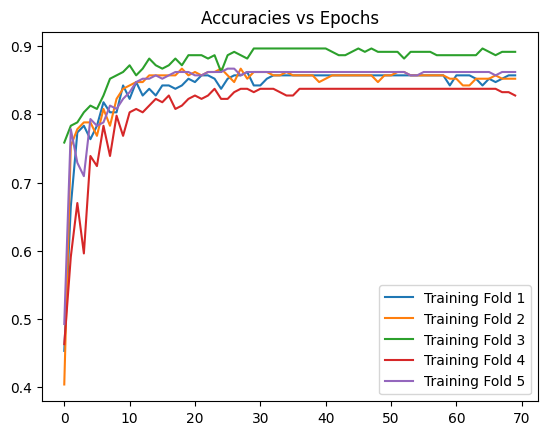

In [107]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['val_accuracy'], label='Training Fold 1')
plt.plot(model_history[1].history['val_accuracy'], label='Training Fold 2')
plt.plot(model_history[2].history['val_accuracy'], label='Training Fold 3')
plt.plot(model_history[3].history['val_accuracy'], label='Training Fold 4')
plt.plot(model_history[4].history['val_accuracy'], label='Training Fold 5')
plt.legend()
plt.show()

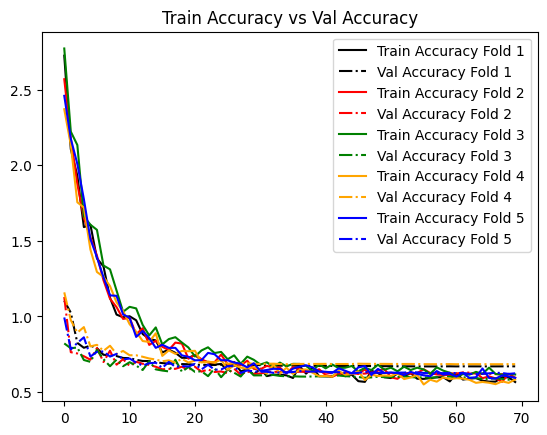

In [108]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['loss'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_loss'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['loss'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_loss'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['loss'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_loss'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.plot(model_history[3].history['loss'], label='Train Accuracy Fold 4', color='orange', )
plt.plot(model_history[3].history['val_loss'], label='Val Accuracy Fold 4', color='orange', linestyle = "dashdot")
plt.plot(model_history[4].history['loss'], label='Train Accuracy Fold 5', color='blue', )
plt.plot(model_history[4].history['val_loss'], label='Val Accuracy Fold 5', color='blue', linestyle = "dashdot")
plt.legend()
plt.show()

Result on val_Fold:  1
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8429 - loss: 0.7022  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step 
Result on val_Fold:  2
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8647 - loss: 0.6148  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step 
Result on val_Fold:  3
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8937 - loss: 0.5774  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step 
Result on val_Fold:  4
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8693 - loss: 0.6154  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step 
Result on val_Fold:  5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8901 - loss: 0.5751  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step 
Average Accuracy: 0.8631 ± 0.0236
Average Sensitivity: 0.6796 ± 0.0677
Average Specificity: 0.9353 ± 0.0293
Average MCC: 0.6464 ± 0.0482
Average ROC AUC: 0.8425 ± 0.0682
Average PR AUC: 0.7409 ± 0.0037


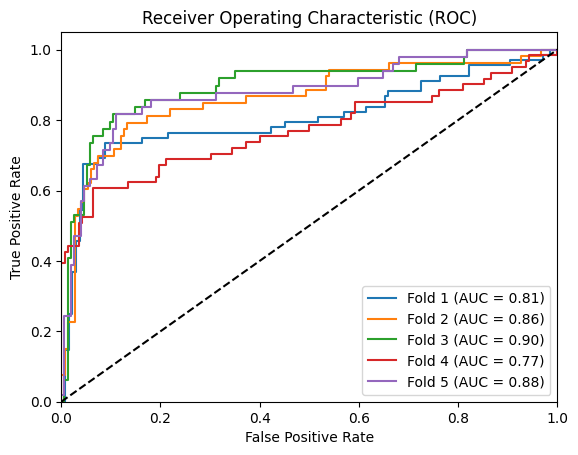

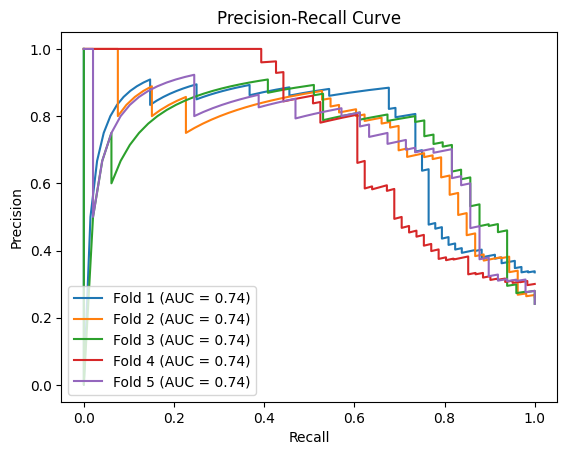

In [110]:
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, confusion_matrix
import matplotlib.pyplot as plt

# Define specificity function
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Initialize lists to store metrics for each fold
mcc_list = []
spe_list = []
sen_list = []
acc_list = []
roc_auc_list = []
pr_auc_list = []

# Initialize lists for plotting
fpr_list = []
tpr_list = []
precision_list = []
recall_list = []

for i in range(5):
    x = str(i)
    print("Result on val_Fold: ", i + 1)
    
    # Load the model and data
    model = load_model('sec_folds_kmer/best_' + str(i) + '_.keras')
    x_val_data1 = np.load('sec_folds_kmer/fold_' + x + '_x_test.npy')
    test_labels = np.load('sec_folds_kmer/fold_' + x + '_y_test.npy')
    ph_x_val_data = np.load('sec_folds_kmer/kmer_fold_' + x + '_x_test.npy')
    ph_y_val = np.load('sec_folds_kmer/kmer_fold_' + x + '_y_test.npy')
        
    # Evaluate the model
    model.evaluate([x_val_data1, ph_x_val_data], test_labels)
    
    # Get predictions
    y_scores = model.predict([x_val_data1, ph_x_val_data])
    
    # Check the shape of y_scores and adjust if necessary
    if y_scores.shape[1] == 1:
        y_scores = np.hstack([1 - y_scores, y_scores])
    
    y_pred = np.argmax(y_scores, axis=1)
    
    # Calculate performance metrics
    acc = accuracy_score(test_labels, y_pred)
    sen = recall_score(test_labels, y_pred)
    spe = specificity(test_labels, y_pred)
    precision = precision_score(test_labels, y_pred, zero_division=1)
    f1 = f1_score(test_labels, y_pred, zero_division=1)
    mcc = matthews_corrcoef(test_labels, y_pred)
    
    # Compute AUC for ROC and PR
    y_scores_pos = y_scores[:, 1]  # Probabilities for the positive class
    fpr, tpr, _ = roc_curve(test_labels, y_scores_pos)
    auc_roc = auc(fpr, tpr)
    precision_, recall_, _ = precision_recall_curve(test_labels, y_scores_pos)
    auc_pr = average_precision_score(test_labels, y_scores_pos)
    
    # Append metrics to lists
    acc_list.append(acc)
    sen_list.append(sen)
    spe_list.append(spe)
    mcc_list.append(mcc)
    roc_auc_list.append(auc_roc)
    pr_auc_list.append(auc_pr)
    
    # Store values for plotting
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    precision_list.append(precision_)
    recall_list.append(recall_)

# Calculate average metrics
avg_acc = np.mean(acc_list)
avg_sen = np.mean(sen_list)
avg_spe = np.mean(spe_list)
avg_mcc = np.mean(mcc_list)
avg_roc_auc = np.mean(roc_auc_list)
avg_pr_auc = np.mean(pr_auc_list)

# Calculate 95% confidence intervals using the percentile method
def calculate_ci(metric_list, confidence_level=95):
    lower = np.percentile(metric_list, (100 - confidence_level) / 2)
    upper = np.percentile(metric_list, 100 - (100 - confidence_level) / 2)
    return lower, upper

acc_ci = calculate_ci(acc_list)
sen_ci = calculate_ci(sen_list)
spe_ci = calculate_ci(spe_list)
mcc_ci = calculate_ci(mcc_list)
roc_auc_ci = calculate_ci(roc_auc_list)
pr_auc_ci = calculate_ci(pr_auc_list)

# Print average metrics with confidence intervals in combined format (± margin)
print(f'Average Accuracy: {avg_acc:.4f} ± {avg_acc - acc_ci[0]:.4f}')
print(f'Average Sensitivity: {avg_sen:.4f} ± {avg_sen - sen_ci[0]:.4f}')
print(f'Average Specificity: {avg_spe:.4f} ± {avg_spe - spe_ci[0]:.4f}')
print(f'Average MCC: {avg_mcc:.4f} ± {avg_mcc - mcc_ci[0]:.4f}')
print(f'Average ROC AUC: {avg_roc_auc:.4f} ± {avg_roc_auc - roc_auc_ci[0]:.4f}')
print(f'Average PR AUC: {avg_pr_auc:.4f} ± {avg_pr_auc - pr_auc_ci[0]:.4f}')

# Plot ROC Curve
plt.figure()
for i in range(5):
    plt.plot(fpr_list[i], tpr_list[i], label=f'Fold {i+1} (AUC = {roc_auc_list[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.savefig('sec_folds_kmer/average_roc_curve.png')
plt.show()

# Plot PR Curve
plt.figure()
for i in range(5):
    plt.plot(recall_list[i], precision_list[i], label=f'Fold {i+1} (AUC = {pr_auc_list[i]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.savefig('sec_folds_kmer/average_pr_curve.png')
plt.show()


In [35]:
def build_model():
    inp1 = Input((275, 4))
    inp2 = Input((1, 1024))

    x1 = Conv1D(64, 7, strides=1, padding='same', activation='relu',
                kernel_regularizer=regularizers.l2(1e-3), bias_regularizer=regularizers.l2(1e-4),
                kernel_initializer='random_normal')(inp1)
    x1 = LayerNormalization()(x1)
    x1 = MaxPooling1D(pool_size=5)(x1)
    x1 = Dropout(0.5)(x1)
    x1 = Conv1D(128, 7, strides=1, padding='same', activation='relu',
                kernel_regularizer=regularizers.l2(1e-3), bias_regularizer=regularizers.l2(1e-4),
                kernel_initializer='random_normal')(x1)
    x1 = LayerNormalization()(x1)
    x1 = MaxPooling1D(pool_size=5)(x1)
    x1 = Dropout(0.5)(x1)
    x1 = Flatten()(x1)
    x2 = Flatten()(inp2)
        # Fully connected layers for the second input (inp2)
    x2 = Dense(64, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-3))(x2)
    x2 = Dropout(0.75)(x2)
    x2 = Flatten()(x2)

    #x2 = Dense(32, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-3))(x2)
    #x2 = Dropout(0.5)(x2)
    
    x = concatenate([x1, x2], axis=1)

    x = Dropout(0.75)(x)
    #x = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(1e-3))(x)
    #x = Dropout(0.5)(x)

    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[inp1, inp2], outputs=x)
    return model
